In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets

### Creating the model

In [2]:
MODELS = {
    "ViT-B/32":       "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
}

In [3]:
!wget {MODELS["ViT-B/32"]} -O model.pt

--2021-03-03 23:28:59--  https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.19, 13.107.213.19, 2620:1ec:bdf::19, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353976522 (338M) [application/octet-stream]
Saving to: ‘model.pt’

model.pt            100%[===================>] 337.58M   133MB/s    in 2.5s    

2021-03-03 23:29:02 (133 MB/s) - ‘model.pt’ saved [353976522/353976522]



In [4]:
model = torch.jit.load("model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

### Downloading the dataset

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
cd gdrive/MyDrive/

/content/gdrive/MyDrive


In [8]:
ls

 Brueghel/
'Brueghel.zip?dl=0'
 devimadmaroufpoly.gdoc
 devimadmaroufpoly.pdf
 exam_ImageUnderstanding-20-21.gdoc
 exam_ImageUnderstanding-20-21.pdf
'Ideas and brainstorming:.gdoc'
 Imad_MAROUF_CV.pdf
 Lab_3_Tracking_MAROUF_MALIK.pdf
 lienzoomjanvierpolyt.docx
'ML Challenge XINF554.gslides'
 model.pt
 MotivationLetter_ImadMAROUF.pdf
 output.zip
'PROCEDURE D’ACCUEIL D’UN PERSONNE A L’U2IS-1.docx'
'Reglement bourse PhD Track.gdoc'
'Reglement bourse PhD Track.pdf'
'RL Project.gdoc'
'texteBgalereultradiplomes1 (1).gdoc'
 texteBgalereultradiplomes1.gdoc
 texteBgalereultradiplomes1.pdf
 texteBgalereultradiplomes2.gdoc
 texteBgalereultradiplomes2.pdf
 Transcript_ImadMAROUF.pdf
'YourNAME_ImageMining_Exam2020 (1).gdoc'
 YourNAME_ImageMining_Exam2020.docx
 YourNAME_ImageMining_Exam2020.gdoc
 YourNAME_ImageMining_Exam2020.pdf


In [9]:
try:
  !rm Brueghel.zip?dl=0
except:
  print("Does not exist")

In [10]:
!rm -rf Brueghel

In [11]:
!wget 'https://www.dropbox.com/s/nljxhtct5d7285h/Brueghel.zip?dl=0'
!unzip Brueghel.zip?dl=0

--2021-03-03 23:29:12--  https://www.dropbox.com/s/nljxhtct5d7285h/Brueghel.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/nljxhtct5d7285h/Brueghel.zip [following]
--2021-03-03 23:29:12--  https://www.dropbox.com/s/raw/nljxhtct5d7285h/Brueghel.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0953d4013709b52d68ce12c0f1.dl.dropboxusercontent.com/cd/0/inline/BKDlm4vIWyLp2Jk7VEI6DljSJJCyft4BL4TpKrRQjppZbIVGuJSNwmm5XORhtFVUYsbXd7O0EzyD-1hK-4eKLm3e_DvWhe6iIuHCyBjLWOanTQ/file# [following]
--2021-03-03 23:29:12--  https://uc0953d4013709b52d68ce12c0f1.dl.dropboxusercontent.com/cd/0/inline/BKDlm4vIWyLp2Jk7VEI6DljSJJCyft4BL4TpKrRQjppZbIVGuJSNwmm5XORhtFVUYsbXd7O0EzyD-1hK-4eKLm3e_DvWhe6iIuHCyBjLWOanTQ/file
Resolving u

### Loading dataset

In [12]:
from torchvision import datasets
import sys, os
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize
import cv2
from PIL import Image
from numpy import asarray

def dataload(path1,  size = (224, 224, 3)):
    """
    inputs: path to images folder
    returns: arrays contains imgs 
    """
    onlyfiles1 = [f for f in os.listdir(path1) if os.path.isfile(os.path.join(path1, f))]
    onlyfiles1.sort()

    visible = np.ndarray(shape=(len(onlyfiles1), size[0], size[1], size[2]), dtype = np.float32)
    i = 0
    for img_name in tqdm(onlyfiles1):
      img_path = path1 + "/" + img_name
      img = np.array(Image.open(img_path, mode="r").resize((size[0], size[1], size[2])))
      visible[i] = img 
    print("\t############# All VISIBLE images to array ##########")
    return visible

def dataLabels(path1):
    onlyfiles1 = [f for f in os.listdir(path1) if os.path.isfile(os.path.join(path1, f))]

    labels = []
    for img_name in tqdm(onlyfiles1):
        labels.append(img_name)

    return labels

In [13]:
main_path = os.path.abspath(os.getcwd())
data_dir = main_path + '/Brueghel/'
print(data_dir)

/content/gdrive/My Drive/Brueghel/


In [14]:
!mv  Brueghel train
!mkdir Brueghel
!mv train Brueghel
!cd Brueghel

In [15]:
dsets = datasets.ImageFolder(root="/content/gdrive/My Drive/Brueghel/", transform=preprocess)

In [16]:
dsets

Dataset ImageFolder
    Number of datapoints: 1587
    Root location: /content/gdrive/My Drive/Brueghel/
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BICUBIC)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [17]:
labels = dataLabels("/content/gdrive/My Drive/Brueghel/train/")

100%|██████████| 1587/1587 [00:00<00:00, 1141546.98it/s]


In [18]:
labels[:10]

['Venus as Ceres with Apollo.jpg',
 'Sheet of Studies of Peasants.jpg',
 'Woodland Scene with Bears.jpg',
 'The Four Elements (Bucharest).jpg',
 'Garden of Eden with Creation of Eve.jpg',
 'View of the Temples of Venus and of Diana in Baia from the South.jpg',
 'Fruit and Flower Garland Around the Virgin and Child (Switzerland).jpg',
 'The Flatterers (Amsterdam).jpg',
 'The Sense of Taste.jpg',
 "The Flood with Noah's Ark (London).jpg"]

In [19]:
data_loader = torch.utils.data.DataLoader(dsets, batch_size=16, shuffle=False, num_workers=6)

### Loading Model

In [20]:
def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [template.format(classname) for template in templates] #format with class
            texts = clip.tokenize(texts).cuda() #tokenize
            class_embeddings = model.encode_text(texts) #embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

In [21]:
print(model)

RecursiveScriptModule(
  original_name=Multimodal
  (visual): RecursiveScriptModule(
    original_name=VisualTransformer
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (ln_pre): RecursiveScriptModule(original_name=LayerNorm)
    (transformer): RecursiveScriptModule(
      original_name=Transformer
      (resblocks): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=ResidualAttentionBlock
          (attn): RecursiveScriptModule(
            original_name=MultiheadAttention
            (out_proj): RecursiveScriptModule(original_name=_LinearWithBias)
          )
          (ln_1): RecursiveScriptModule(original_name=LayerNorm)
          (mlp): RecursiveScriptModule(
            original_name=Sequential
            (c_fc): RecursiveScriptModule(original_name=Linear)
            (gelu): RecursiveScriptModule(original_name=QuickGELU)
            (c_proj): RecursiveScriptModule(original_name=Linear)
          )
   

In [22]:
def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
device

'cuda'

### Image Ranking using Max-Pooling

In [25]:
model = torch.jit.load("model.pt").cuda().eval()

for param in model.parameters():
    param.requires_grad = False

In [26]:
import torch.nn as nn

class MyModel(nn.Module):
  def __init__(self, input_resolution: int, patch_size: int, width: int):
    super(MyModel, self).__init__()
    #self.get_features = torch.nn.Sequential(*(list(model.visual.children())[:1]))
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)
    output_size = (1,1)
    self.pooling = nn.AdaptiveMaxPool2d(output_size)
  
  def forward(self, image):
    out = self.conv1(image)
    logit = self.pooling(out)
    #logit /= torch.sum(logit)
    return logit

In [27]:
vision_width = model.visual.conv1.weight.shape[0]
vision_patch_size = model.visual.conv1.weight.shape[-1]

grid_size = round((model.visual.positional_embedding.shape[0] - 1) ** 0.5)
image_resolution = vision_patch_size * grid_size
vision_heads = vision_width // 64

In [28]:
print("vision_width", vision_width)
print("vision_patch_size", vision_patch_size)
print("grid_size", grid_size)
print("image_resolution", image_resolution)
print("vision_heads", vision_heads)

vision_width 768
vision_patch_size 32
grid_size 7
image_resolution 224
vision_heads 12


In [29]:
conv = MyModel(input_resolution = image_resolution, patch_size = vision_patch_size, width = vision_width)
#conv = nn.Conv2d(in_channels=3, out_channels=vision_width, kernel_size=vision_patch_size, stride=vision_patch_size, bias=False)
print(conv)
for param in conv.parameters():
  print(param.shape)

weights_conv = model.visual.conv1.weight
print("Initial ViT Model weights: ", weights_conv.shape)

#Giving the weights of initial CLIP ViT to the convolution network
with torch.no_grad():
    conv.conv1.weight = torch.nn.Parameter(weights_conv.type(torch.FloatTensor))

MyModel(
  (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
  (pooling): AdaptiveMaxPool2d(output_size=(1, 1))
)
torch.Size([768, 3, 32, 32])
Initial ViT Model weights:  torch.Size([768, 3, 32, 32])


In [30]:
images, labels = next(iter(data_loader))
print("Images shape: ", images.shape)

Images shape:  torch.Size([16, 3, 224, 224])


In [31]:
img = images[1].unsqueeze(0)
print(img.shape)

torch.Size([1, 3, 224, 224])


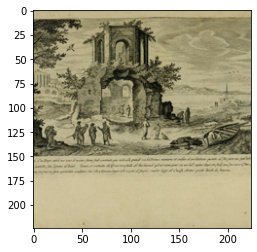

In [32]:
plt.imshow(img[0].permute(1, 2, 0).detach().numpy())

In [33]:
conv = conv.eval()
print(img.dtype)
target_img = conv(img)
target_img.shape

torch.float32


torch.Size([1, 768, 1, 1])

In [34]:
def preconvfeat(dataloader):
    conv_features = []
    imgs = []
    for data in dataloader:
        input, label = data
        for i in range(input.shape[0]):
          img = input[i].to(device)
          img = img.unsqueeze(0)
          x = conv(img)
          imgs.append(img)
          conv_features.append(x.data.cpu().numpy())
    
    return conv_features, imgs

In [35]:
conv = conv.to(device)
features, images = preconvfeat(data_loader)

In [36]:
def calculate_distances(target, targetID, conv_features, nbr = 5):
  distances = []
  for i, img_conv in enumerate(conv_features):
    distance = np.linalg.norm(target.cpu().detach().numpy() - img_conv)
    if i != targetID: 
      distances.append(distance)

  indices = np.argsort(distances)[:nbr]
  return distances, indices

In [37]:
print("Length of Features: ", len(features))
print("Each feature shape: ", features[0].shape)

print("Dataset images: ", len(images))
print("Image shape: ", images[0].shape)

Length of Features:  1587
Each feature shape:  (1, 768, 1, 1)
Dataset images:  1587
Image shape:  torch.Size([1, 3, 224, 224])


In [38]:
dist, indices = calculate_distances(target_img, 1, features)

In [40]:
def get_similar(images, indices):
  ret_imgs = []
  for i, value in enumerate(indices):
    ret_imgs.append(images[value])
  return ret_imgs

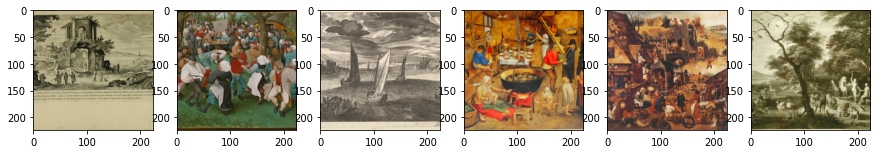

In [41]:
ret_imgs = get_similar(images, indices)
fix, ax = plt.subplots(1, 6, figsize=(15, 10))

ax[0].imshow(img[0].permute(1, 2, 0).detach().numpy())
for i in range(0, 5):
  ax[i+1].imshow(ret_imgs[i][0].permute(1, 2, 0).cpu().detach().numpy())


In [42]:
def generate_samples(dataset, nbr = 5):
  random_imgs = np.random.randint(0, 1500, nbr)
  samples = []

  for i in random_imgs:
    samples.append(dataset[i][0].unsqueeze(0))
  return samples, random_imgs

samples, ind = generate_samples(dsets, 5)

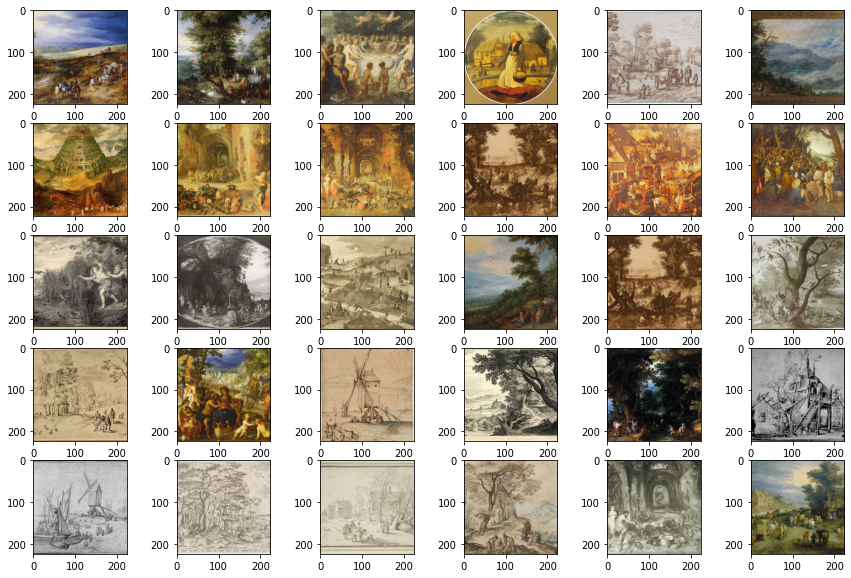

In [43]:
fix, ax = plt.subplots(5, 6, figsize=(15, 10))

for i in range(0, 5):
  ax[i][0].imshow(samples[i][0].permute(1, 2, 0).cpu().detach().numpy())
  conv = conv.to(device)
  target_img = conv(samples[i].to(device))
  targetID = ind[i]
  dist, indices = calculate_distances(target_img, targetID, features)
  ret_imgs = get_similar(images, indices)
  for j in range(0, 5):
    ax[i][j+1].imshow(ret_imgs[j][0].permute(1, 2, 0).cpu().detach().numpy())

### Regional Max-Pooling

In [44]:
from torchvision import datasets, transforms, models

input_resolution = 800
transformation = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])
dsets = datasets.ImageFolder(root="/content/gdrive/My Drive/Brueghel/", transform=transformation)

In [45]:
dsets

Dataset ImageFolder
    Number of datapoints: 1587
    Root location: /content/gdrive/My Drive/Brueghel/
    StandardTransform
Transform: Compose(
               Resize(size=800, interpolation=PIL.Image.BICUBIC)
               CenterCrop(size=(800, 800))
               ToTensor()
           )

In [46]:
data_loader = torch.utils.data.DataLoader(dsets, batch_size=16, shuffle=False, num_workers=6)

In [47]:
import math
import torch.nn.functional as F

def rmac(x, L=3, eps=1e-6):
    ovr = 0.4 # desired overlap of neighboring regions
    steps = torch.Tensor([2, 3, 4, 5, 6, 7]) # possible regions for the long dimension

    W = x.size(3)
    H = x.size(2)

    w = min(W, H)
    w2 = math.floor(w/2.0 - 1)

    b = (max(H, W)-w)/(steps-1)
    (tmp, idx) = torch.min(torch.abs(((w**2 - w*b)/w**2)-ovr), 0) # steps(idx) regions for long dimension

    # region overplus per dimension
    Wd = 0;
    Hd = 0;
    if H < W:  
        Wd = idx.item() + 1
    elif H > W:
        Hd = idx.item() + 1

    v = F.max_pool2d(x, (x.size(-2), x.size(-1)))
    v = v / (torch.norm(v, p=2, dim=1, keepdim=True) + eps).expand_as(v)

    for l in range(1, L+1):
        wl = math.floor(2*w/(l+1))
        wl2 = math.floor(wl/2 - 1)

        if l+Wd == 1:
            b = 0
        else:
            b = (W-wl)/(l+Wd-1)
        cenW = torch.floor(wl2 + torch.Tensor(range(l-1+Wd+1))*b) - wl2 # center coordinates
        if l+Hd == 1:
            b = 0
        else:
            b = (H-wl)/(l+Hd-1)
        cenH = torch.floor(wl2 + torch.Tensor(range(l-1+Hd+1))*b) - wl2 # center coordinates
            
        for i_ in cenH.tolist():
            for j_ in cenW.tolist():
                if wl == 0:
                    continue
                R = x[:,:,(int(i_)+torch.Tensor(range(wl)).long()).tolist(),:]
                R = R[:,:,:,(int(j_)+torch.Tensor(range(wl)).long()).tolist()]
                vt = F.max_pool2d(R, (R.size(-2), R.size(-1)))
                vt = vt / (torch.norm(vt, p=2, dim=1, keepdim=True) + eps).expand_as(vt)
                v += vt

    return v

In [48]:
model = torch.jit.load("model.pt").cuda().eval()

for param in model.parameters():
    param.requires_grad = False

class MyModel2(nn.Module):
  def __init__(self, input_resolution: int, patch_size: int, width: int):
    super(MyModel2, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=(3, 3), bias=False)
    output_size = (1,1)
    self.pooling = nn.AdaptiveMaxPool2d(output_size)
  
  def forward(self, image):
    out = self.conv1(image)             #[1, 768, 257, 257]
    #logit = self.pooling(out)
    #logit /= torch.sum(logit)
    #Regional Max-Pooling
    return rmac(out)

In [49]:
vision_width = model.visual.conv1.weight.shape[0]
vision_patch_size = model.visual.conv1.weight.shape[-1]

grid_size = round((model.visual.positional_embedding.shape[0] - 1) ** 0.5)
image_resolution = vision_patch_size * grid_size
vision_heads = vision_width // 64

print("vision_width", vision_width)
print("vision_patch_size", vision_patch_size)
print("grid_size", grid_size)
print("image_resolution", image_resolution)
print("vision_heads", vision_heads)

vision_width 768
vision_patch_size 32
grid_size 7
image_resolution 224
vision_heads 12


In [50]:
conv = MyModel2(input_resolution = image_resolution, patch_size = vision_patch_size, width = vision_width)

print(conv)
for param in conv.parameters():
  print(param.shape)

weights_conv = model.visual.conv1.weight
print("Initial ViT Model weights: ", weights_conv.shape)

#Giving the weights of initial CLIP ViT to the convolution network
with torch.no_grad():
    conv.conv1.weight = torch.nn.Parameter(weights_conv.type(torch.FloatTensor))

MyModel2(
  (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(3, 3), bias=False)
  (pooling): AdaptiveMaxPool2d(output_size=(1, 1))
)
torch.Size([768, 3, 32, 32])
Initial ViT Model weights:  torch.Size([768, 3, 32, 32])


In [51]:
data_loader

In [52]:
image, label = next(iter(dsets))
print("Images shape: ", image.shape)

Images shape:  torch.Size([3, 800, 800])


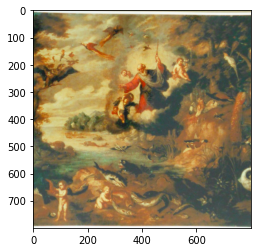

In [53]:
plt.imshow(image.permute(1, 2, 0).detach().numpy())

In [54]:
conv = conv.eval()
image = image.unsqueeze(0)
print(image.shape)
target_img = conv(image)
target_img.shape

torch.Size([1, 3, 800, 800])


torch.Size([1, 768, 1, 1])

In [55]:
conv = conv.to(device)
features, images = preconvfeat(data_loader)

dist, indices = calculate_distances(target_img, 0, features)

RuntimeError: ignored

In [ ]:
ret_imgs = get_similar(images, indices)
fix, ax = plt.subplots(1, 6, figsize=(15, 10))

ax[0].imshow(img[0].permute(1, 2, 0).detach().numpy())
for i in range(0, 5):
  ax[i+1].imshow(ret_imgs[i][0].permute(1, 2, 0).cpu().detach().numpy())
